## Pretraining

Let's Initialize our model

In [1]:
import os
os.chdir("../")

In [2]:
from src.GPT_model import GPTModel

GPT2_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True
}

model = GPTModel(GPT2_CONFIG_124M)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): NormalizationLayer()
      (norm2): NormalizationLayer()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_que

Let's implement some useful functions that will transform text to token ids and viceversa. The image below illustrates how these functions work

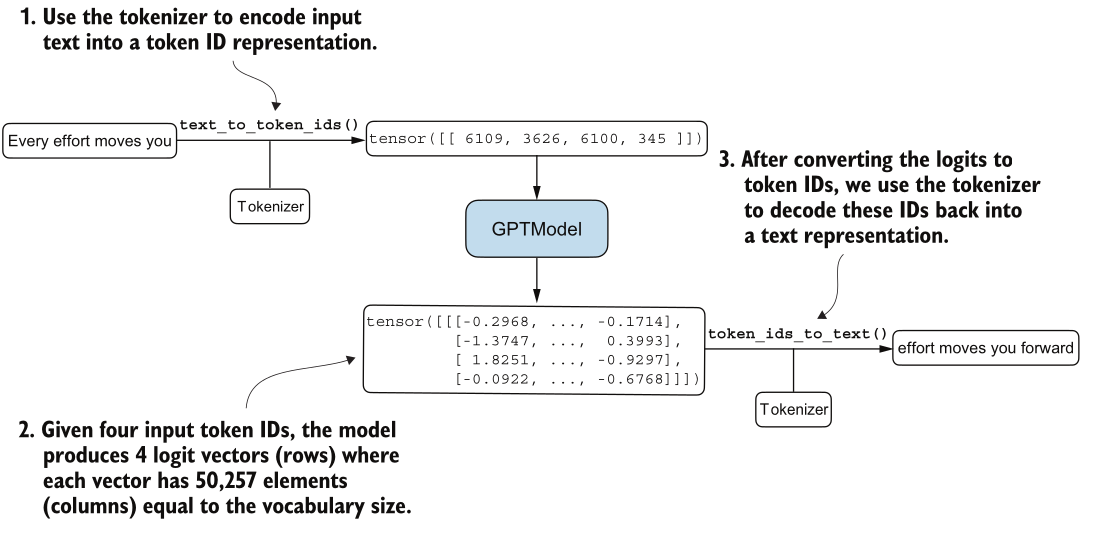

In [3]:
import tiktoken
import torch
from src.utils import generate_text

def text_to_token_ids(text, tokenizer):
    """
    Transforms text into a tensor of  token IDs  of size (batch_size, seq_length) 

    Args:
        text: the text to be tokenized
        tokenizer: A tokenizer to be used 
    """
    token_ids = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    token_ids_tensor = torch.tensor(token_ids).unsqueeze(0) # unsqueeze will add batch dimension
    return token_ids_tensor

In [4]:
import tiktoken
import torch
from src.utils.generate_text import generate_text

def token_ids_to_text(token_ids, tokenizer):
    """
    Transforms tensor of  token IDs  of size (batch_size, seq_length) into text 

    Args:
        token_ids: the token IDs to transform into text 
        tokenizer: A tokenizer to be used 
    """
    token_ids_flat = token_ids.squeeze(0)
    return tokenizer.decode(token_ids_flat.tolist())

In [5]:
# start_context = "I like pizza"
tokenizer = tiktoken.get_encoding("gpt2")

# token_ids = generate_text(model, text_to_token_ids(start_context, tokenizer),10, GPT2_CONFIG_124M["context_length"])
# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

## Loss and Cross Entropy Loss

We seem to be generating proper text, the only problem is that the text is completely unrelated with the context. To solve this we need to pretrain our model. 

In order to pretrain the model we need to define a **loss metric** for the generated outputs; this loss will serves as a progress indicator of our training. Part of the evaluation process will include a measurement of how far the generated tokes are from the correct predictions. The training function will later use this information to update the model weights. Basically, the training consists of increasing the softmax probability of the index positions corresponding to the correct target token IDs. 

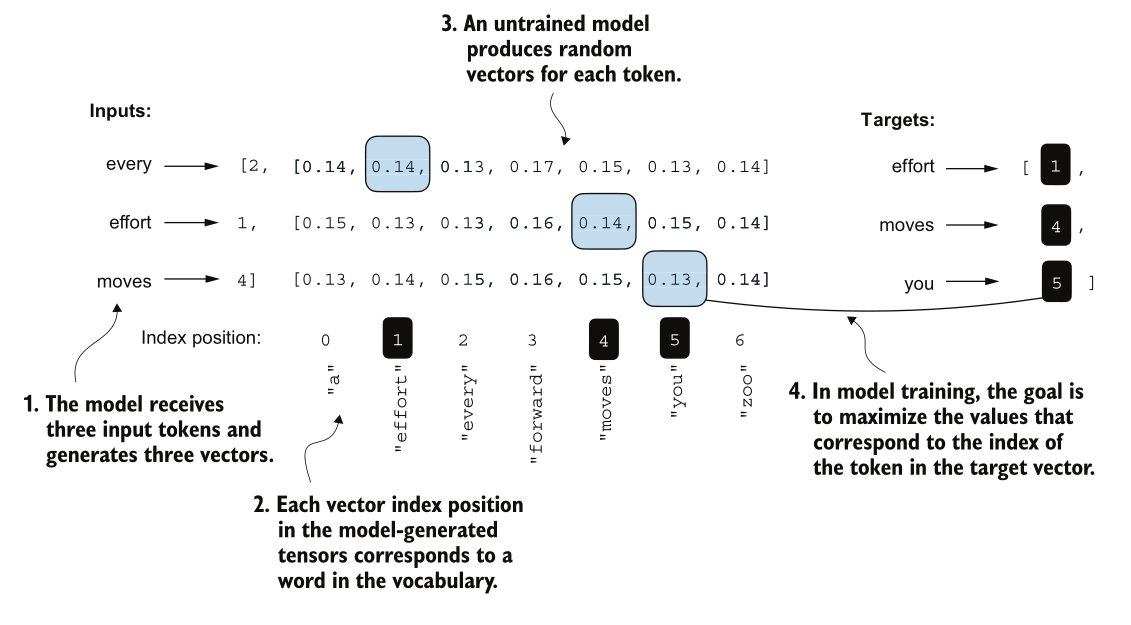

The main steps for calculating the loss are as follows:


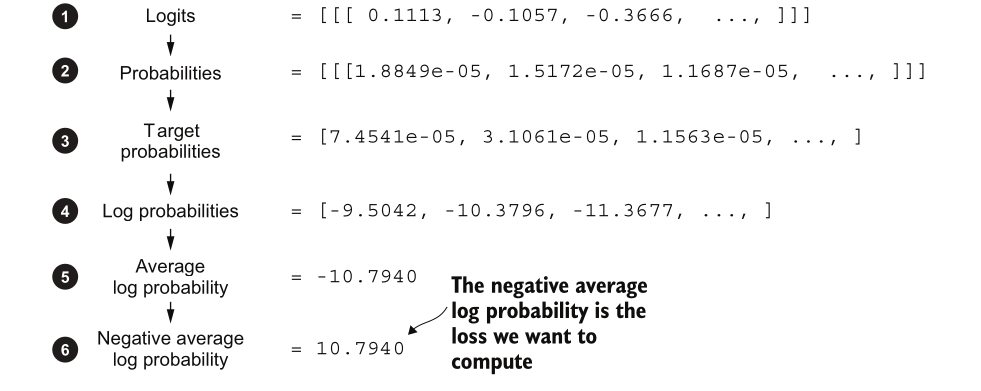

1. We will have an input tensor of token ids of size (batch_size, seq_len)
2. Obtain the logits by passing the input tensor to the model obtaining a tensor of size: (batch_size, seq_len, vocab_size)
3. Apply the softmax to those logits. Basically apply the softmax to every distribution given above.
4. Obtain the probabilities of the target tokens. This is done by probas[batch_num, [1,..., seq_len], targets[batch_num]]. Basically we pick the batch, then the distribution corresponding to our token, and then what value we want of that distribution.
5. get the log proprobabilities from above
6. Find the average log probs and negate it 

In other words the neg log likelihood is the loss we want to compute

Our goal is therefore to get the average negative log probabilities as close to 0 as possible by updating the model's weights as part of the training process: this is know as **cross entropy**

cross entropy at its core measures the difference between two probability distributions, typically the true distribution and the predicted distribution from the model.

In the context of PyTorch, the cross_entropy function computes this measure for discrete outcomes, which is similar to the negative average log probability of the target tokens given the model's generated token probabilities, making the term cross entropy and “negative average log probability” related and often used interchangeably in practice.

## Calculating the training and validation set losses

I will train the model with the book "Afterward" by Edith Wharthon. We need to split this book into train and test sets.

In [6]:
try: 
    with open("data/Afterward-Edith-Wharton.txt", "r") as file:
        text = file.read()
except Exception as e:
    print("Error opening the file.")
print(len(text))

67689


In [7]:
split_idx = int(0.9 * len(text))
train_data = text[:split_idx]
test_data = text[split_idx:]

Let's now use the dataloader function we created

In [8]:
from src.token_embedding_layer import createGPTDataLoader

train_dataloader = createGPTDataLoader(text=train_data,
                                       batch_size=2,
                                       context_size=GPT2_CONFIG_124M["context_length"],
                                       stride=GPT2_CONFIG_124M["context_length"],
                                       )
test_dataloader = createGPTDataLoader(text=test_data,
                                      batch_size=2,
                                      context_size=GPT2_CONFIG_124M["context_length"],
                                      stride=GPT2_CONFIG_124M["context_length"])

Let's now implement a utility function that will calculate the cross entropy loss of a given batch returned by the training or test data loaders.

In [9]:
def calc_batch_loss(input_batch, target_batch, model, device):
    """
    Calculates how the model performs on a specific batch 
    """
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

Given this we can calculate the loss over all batches sampled by a data loader

In [10]:
def calculate_loss(data_loader, model, device, num_batches=None):
    """
    Calculates how the model performs on average on a set of batches
    """
    total_loss=0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches =  min(len(data_loader), num_batches)

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_batch_loss(input_batch=input_batch, target_batch=target_batch, model=model, device=device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # average loss per batch
        
    

Let's apply this function to our train and test loaders to see the loss.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calculate_loss(train_dataloader, model, device)
    test_loss = calculate_loss(test_dataloader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", test_loss)
device


/home/armando-albornoz/Desktop/resumeProjects/LLM_Project/env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Training the LLM

The training process is summarized by the image below

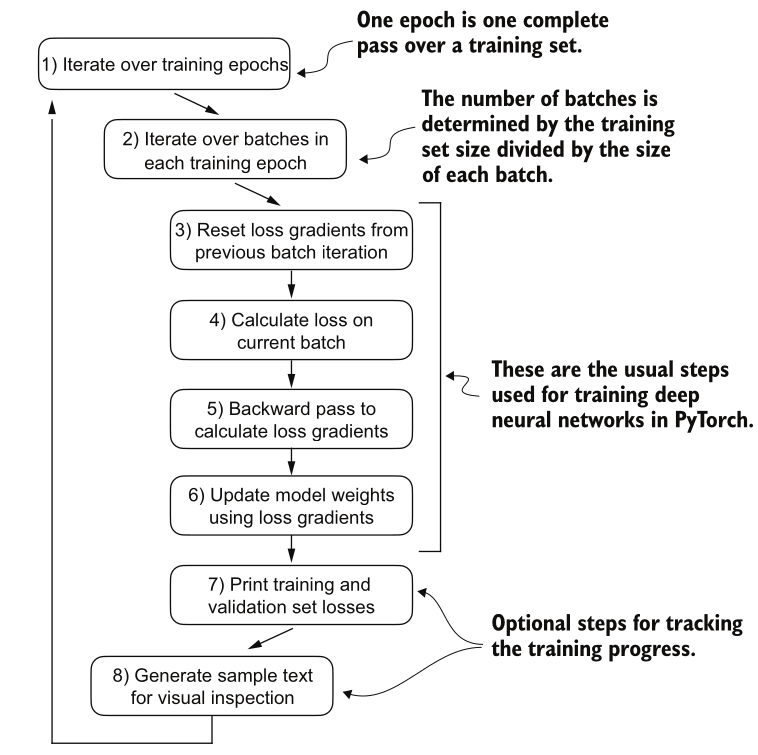

In [ ]:

def evaluate_model(model, train_dataloader, test_dataloader, device, eval_iter):
    """
    Calculates how the model has performed so far 
    """
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss(train_dataloader, model, device, eval_iter)
        test_loss = calculate_loss(test_dataloader, model, device, eval_iter)

    model.train()
    return train_loss, test_loss

def train_model(model, train_dataloader, test_dataloader, optimizer, device, 
                num_epochs, eval_freq, eval_iter):
    train_losses, test_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad()  # Resets loss gradients from previous batch
            loss = calc_batch_loss(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # Evaluation logic
            if global_step % eval_freq == 0:
                train_loss, test_loss = evaluate_model(model, train_dataloader, test_dataloader, device, eval_iter)
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "f"Train loss {train_loss:.3f}, "f"Val loss {test_loss:.3f}")
                
    return train_losses, test_losses, track_tokens_seen

Let's now train our model

In [ ]:

import os 

if not os.path.exists("artifacts/model/model_and_optimizer.pth"):
    model = GPTModel(GPT2_CONFIG_124M)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
    num_epochs = 10
    train_losses, val_losses, tokens_seen = train_model(
    model, train_dataloader, test_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    )

Ep 1 (Step 000000): Train loss 9.028, Val loss 8.724
Ep 1 (Step 000005): Train loss 6.799, Val loss 6.597
Ep 1 (Step 000010): Train loss 6.317, Val loss 6.069
Ep 1 (Step 000015): Train loss 6.185, Val loss 5.849
Ep 1 (Step 000020): Train loss 5.581, Val loss 5.631
Ep 1 (Step 000025): Train loss 5.545, Val loss 5.575
Ep 1 (Step 000030): Train loss 5.625, Val loss 5.508
Ep 2 (Step 000035): Train loss 5.602, Val loss 5.526
Ep 2 (Step 000040): Train loss 5.218, Val loss 5.432
Ep 2 (Step 000045): Train loss 5.245, Val loss 5.467
Ep 2 (Step 000050): Train loss 5.149, Val loss 5.454
Ep 2 (Step 000055): Train loss 5.161, Val loss 5.413
Ep 2 (Step 000060): Train loss 4.811, Val loss 5.361
Ep 3 (Step 000065): Train loss 4.952, Val loss 5.381
Ep 3 (Step 000070): Train loss 4.816, Val loss 5.386
Ep 3 (Step 000075): Train loss 5.035, Val loss 5.382
Ep 3 (Step 000080): Train loss 4.657, Val loss 5.333
Ep 3 (Step 000085): Train loss 4.992, Val loss 5.310
Ep 3 (Step 000090): Train loss 4.859, Val loss

As It can be seen from the output above the loss as gone down quite substantially. Notice however that we have some overfitting.

## Saving Model Weights

Let's now save the model and its optimizer

In [ ]:
import os 

if not os.path.exists("artifacts/model/model_and_optimizer.pth"):
    torch.save({"model_state_dict": model.state_dict(),"optimizer_state_dict": optimizer.state_dict() }, "artifacts/model/model_and_optimizer.pth")

RuntimeError: Parent directory artifacts/model does not exist.

## Loading Pretrained weights from OpenAI

Note that OpenAI originally saved the GPT-2 weights via TensorFlow, which we have to install to load the weights in Python. Let's get a module to download weights. 

In [ ]:
import urllib.request

if not os.path.exists("src/utils/gpt_download.py"):
    url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
    )
    filename = url.split('/')[-1]
    urllib.request.urlretrieve(url, filename)

In [ ]:
from src.utils.gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

2025-08-22 15:26:04.011279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-22 15:26:04.043640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-22 15:26:04.970931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
settings

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

In [ ]:
# Let's inspect the output

print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
GPT2_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True
}

Let's initialize the new model

In [ ]:
gpt = GPTModel(GPT2_CONFIG_124M)
gpt.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): NormalizationLayer()
      (norm2): NormalizationLayer()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_qu

When we initialize the model the weights are randomly set. The last thing we need to do is to override these weights with the weights we loaded. In order to do this we will create a function that receive two tensors, checks if they are the same size, and returns the right tensor as trainable PyTorch parameter.

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

Let's now load the weights

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_block[b].att.W_query.weight = assign(
            gpt.transformer_block[b].att.W_query.weight, q_w.T)
        gpt.transformer_block[b].att.W_key.weight = assign(
            gpt.transformer_block[b].att.W_key.weight, k_w.T)
        gpt.transformer_block[b].att.W_value.weight = assign(
            gpt.transformer_block[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_block[b].att.W_query.bias = assign(
            gpt.transformer_block[b].att.W_query.bias, q_b)
        gpt.transformer_block[b].att.W_key.bias = assign(
            gpt.transformer_block[b].att.W_key.bias, k_b)
        gpt.transformer_block[b].att.W_value.bias = assign(
            gpt.transformer_block[b].att.W_value.bias, v_b)

        gpt.transformer_block[b].att.out_proj.weight = assign(
            gpt.transformer_block[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_block[b].att.out_proj.bias = assign(
            gpt.transformer_block[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_block[b].ff.layers[0].weight = assign(
            gpt.transformer_block[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_block[b].ff.layers[0].bias = assign(
            gpt.transformer_block[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_block[b].ff.layers[2].weight = assign(
            gpt.transformer_block[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_block[b].ff.layers[2].bias = assign(
            gpt.transformer_block[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_block[b].norm1.scale = assign(
            gpt.transformer_block[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_block[b].norm1.shift = assign(
            gpt.transformer_block[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_block[b].norm2.scale = assign(
            gpt.transformer_block[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_block[b].norm2.shift = assign(
            gpt.transformer_block[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_normalization.scale = assign(gpt.final_normalization.scale, params["g"])
    gpt.final_normalization.shift = assign(gpt.final_normalization.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): NormalizationLayer()
      (norm2): NormalizationLayer()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_qu

In [ ]:
from src.utils.generate_text import generate_text

token_ids = generate_text(
    model=gpt,
    token_ids=text_to_token_ids("I like pizza with", tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT2_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 I like pizza with bacon and tomatoes. For whatever reason, I don't feel that a pizza that is completely made in-house is a good
